In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.formula.api as sm
import re
from stargazer.stargazer import Stargazer
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_stata('~/Desktop/Econ 191/Data/Default Tips/20130098_code_data/data/tips2009_clean.dta')
dfz = pd.read_csv('~/Desktop/Econ 191/Data/The Effects of Tip Recommendations on Customer Tipping, Satisfaction, Repatronage, and Spending/tips_fix.csv')

In [3]:
df.columns

Index(['vendor', 'fare', 'tip', 'ride_duration', 'distance', 'pkp_time',
       'drf_time', 'pkp_fips', 'drf_fips', 'tip_frac', 'tip_zero', 'menu_tip',
       'high_choice', 'med_choice', 'low_choice', 'imen_tip', 'iman_tip',
       'pkp_long', 'pkp_lat', 'pkp_boro', 'pkp_day', 'pkp_dow', 'pkp_doy',
       'pkp_hour', 'pkp_id', 'pkp_vendor_avg', 'drf_long', 'drf_lat',
       'drf_boro', 'drf_day', 'drf_dow', 'drf_id', 'tag_pkp_tract',
       'tag_drf_tract', 'tag_farevend', 'gross_income_All', 'gr_inc10_All',
       'gross_income_NonMan', 'gr_inc10_NonMan', 'gross_income_LGA',
       'gr_inc10_LGA', 'gross_income_LGANonMan', 'gr_inc10_LGANonMan',
       'passenger_count', 'trip_time', 'payment_type', 'car_id', 'driver_id',
       'shift', 'from_jfk', 'tipfrac_over0under10', 'tip25', 'dsc_15',
       'amt1_15', 'amt2_15', 'amt3_15', 'amt4_15', 'amt5_15', 'dscXamt1_15',
       'dscXamt2_15', 'dscXamt3_15', 'dscXamt4_15', 'dscXamt5_15',
       'amt_tip_frac_vendcomp', 'amt_tip_frac_vend_1

In [4]:
dfz.columns

Index(['invoice_guid', 'order_guid', 'city', 'invoice_datetime',
       'gross_revenue', 'discount', 'coupon_discount',
       'first_time_user_discount', 'order_rating', 'has_wash_and_fold',
       'has_dry_cleaning', 'user_guid', 'user_email', 'is_first_order',
       'is_enterprise_order', 'pickup_datetime', 'pickup_arrival_datetime',
       'dropoff_datetime', 'dropoff_arrival_datetime', 'zip',
       'pickup_driver_id', 'dropoff_driver_id', 'amount', 'is_refund',
       'is_percent', 'tip_description', 'percent', 'tip_datetime', 'time_zone',
       'tip_was_post_invoice', 'two_tip_first_amount', 'tip_default_plan',
       'is_in_plan', 'tip_preference_created_at', 'tip_preference_expired_at',
       'tip_preference_description', 'tip_preference_amount',
       'tip_preference_percent', 'tip_preference_is_percent',
       'is_enterprise_account', 'first_invoice_datetime',
       'last_invoice_datetime', 'first_invoice_guid', 'last_invoice_guid'],
      dtype='object')

In [5]:
"""
sum(dfs['high_choice'].dropna()) + sum(dfs['med_choice'].dropna()) + sum(dfs['low_choice'].dropna())
tip_recs = pd.DataFrame(data={'Customers (1000s)': [sum(dfs['high_choice'].dropna()), sum(dfs['med_choice'].dropna()), sum(dfs['low_choice'].dropna())], 'Recommendation': ['high', 'med', 'low']})
sns.barplot(x = 'Recommendation', y = 'Customers (1000s)', data=tip_recs);
#
#
mean_custom = np.mean(dfs[dfs['menu_tip'] == 0]['tip'])
median_custom = np.median(dfs[dfs['menu_tip'] == 0]['tip'])
print(mean_custom, median_custom)
#
#
non_zero_tips = dfs[dfs['tip'] != 0]
mean_custom = np.mean(dfs[dfs['menu_tip'] == 1]['tip'])
median_custom = np.median(dfs[dfs['menu_tip'] == 1]['tip'])
print('w/zero:', mean_custom, median_custom)
"""

"\nsum(dfs['high_choice'].dropna()) + sum(dfs['med_choice'].dropna()) + sum(dfs['low_choice'].dropna())\ntip_recs = pd.DataFrame(data={'Customers (1000s)': [sum(dfs['high_choice'].dropna()), sum(dfs['med_choice'].dropna()), sum(dfs['low_choice'].dropna())], 'Recommendation': ['high', 'med', 'low']})\nsns.barplot(x = 'Recommendation', y = 'Customers (1000s)', data=tip_recs);\n#\n#\nmean_custom = np.mean(dfs[dfs['menu_tip'] == 0]['tip'])\nmedian_custom = np.median(dfs[dfs['menu_tip'] == 0]['tip'])\nprint(mean_custom, median_custom)\n#\n#\nnon_zero_tips = dfs[dfs['tip'] != 0]\nmean_custom = np.mean(dfs[dfs['menu_tip'] == 1]['tip'])\nmedian_custom = np.median(dfs[dfs['menu_tip'] == 1]['tip'])\nprint('w/zero:', mean_custom, median_custom)\n"

<h3>                Figure 2:</h3>
$$y_i ~ = ~ \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} + \epsilon_i$$


<br>
<center> $y_i$: tip fraction of the total bill for observation $i$
<br><center> $x_{i,1}$: environment dummy for observation $i$ (1 for online, 0 for in person)
<br><center> $x_{i,2}$: normalized fare price for observation $i$
<br><center> We are interested in the significance of $\hat{\beta_1}$.

In [6]:
dfs = df
df_in_person = df
df_online = dfz

def percent_func(x):
    array = re.findall('^[^$]*$', x)
    if array != []:
        return array[0]
def contains_25(x):
    if re.findall('^.*25.*$', x) != []:
        array = re.findall('^.*25.*$', x)
        return 20
    
df_online['percent_menu_tips'] = df_online['tip_default_plan'].astype(str).apply(percent_func)
df_online['percent_menu_tips'] = df_online['percent_menu_tips'].astype(str).apply(contains_25)
df_online = df_online[df_online['percent_menu_tips'] == 20]
df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100
df_online = df_online[['percent_menu_tips', 'amount', 'tip_percent', 'gross_revenue']]
df_online['fare'] = df_online['gross_revenue']
df_online['tip'] = df_online['amount']
df_online['tip_frac'] = df_online['tip_percent']
df_online['median_menu_tip'] = df_online['percent_menu_tips']
df_online = df_online[['fare', 'tip_frac']]

df_in_person = df_in_person[['fare', 'tip_frac', 'vendor']]
df_in_person = df_in_person[df_in_person['vendor'] == 'Competitor']
df_in_person = df_in_person[['fare', 'tip_frac']]

df_online_orig = df_online
df_in_person_orig = df_in_person

In [7]:
print('online fare median:', np.median(df_online['fare']), 'online fare mean:', np.mean(df_online['fare']))
print('in-person fare median:', np.median(df_in_person['fare']), 'in-person fare mean:', np.mean(df_in_person['fare']))

online fare median: 49.77 online fare mean: 64.30504532932343
in-person fare median: 8.1 in-person fare mean: 9.690212687012997


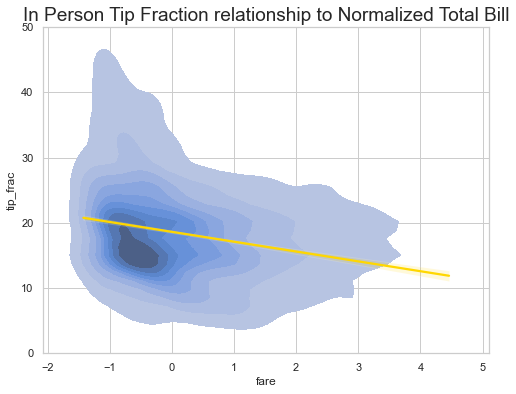

In [131]:
df_in_person = df_in_person_orig
df_online = df_online_orig

df_online = df_online[df_online['fare'] < 100]
mean_online = np.mean(df_online['fare'])
sd_online = np.std(df_online['fare'])
def normalize_online(x):
    return (x - mean_online)/sd_online
df_online['fare'] = df_online['fare'].apply(normalize_online)
df_online = df_online[['fare', 'tip_frac']]



#normalize in_person fare
df_in_person = df_in_person[df_in_person['fare'] < 30]
mean_in_person = np.mean(df_in_person['fare'])
sd_in_person = np.std(df_in_person['fare'])
def normalize_in_person(x):
    return (x - mean_in_person)/sd_in_person
df_in_person['fare'] = df_in_person['fare'].apply(normalize_in_person)
df_in_person = df_in_person[['tip_frac', 'fare']]

sns.set(rc={"figure.figsize":(8, 6)})
sns.set_style("whitegrid")

df_in_person = df_in_person.sample(10000)
df_in_person = df_in_person[df_in_person['tip_frac']>0]
sns.kdeplot('fare', 'tip_frac', data=df_in_person, shade=True)
sns.regplot(x="fare", y="tip_frac", data=df_in_person, scatter=False, color="gold");

"""df_online = df_online.sample(5000)
df_online = df_online[df_online['tip_frac']>0]
sns.kdeplot('fare', 'tip_frac', data=df_online, shade=False)"""

plt.title("In Person Tip Fraction relationship to Normalized Total Bill", fontdict = {'fontsize' : 19})
plt.ylim(0, 50);

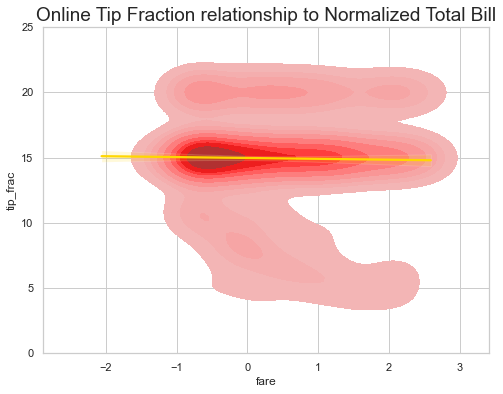

In [132]:
sns.set(rc={"figure.figsize":(8, 6)})
sns.set_style("whitegrid")
df_online.size
df_online = df_online.sample(10000)
df_online = df_online[df_online['tip_frac']>0]
sns.kdeplot('fare', 'tip_frac', color="red", data=df_online, shade=True)
sns.regplot(x="fare", y="tip_frac", data=df_online, scatter=False, color="gold");

plt.title("Online Tip Fraction relationship to Normalized Total Bill", fontdict = {'fontsize' : 19})
plt.ylim(0, 25);

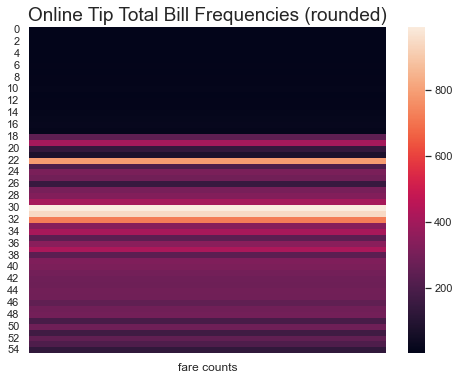

In [135]:
df_online = df_online_orig
df_in_person = df_in_person_orig

sns.set(rc={"figure.figsize":(8, 6)})
df_online = df_online[df_online['fare'] < 60]
df_online['fare'] = df_online['fare'].apply(round)
df_online = df_online.groupby('fare').size().reset_index(name='fare counts')
#sns.scatterplot(x='fare', y='tip_frac', data=df_in_person)
res = sns.heatmap(df_online[['fare counts']])
plt.title("Online Tip Total Bill Frequencies (rounded)", fontdict = {'fontsize' : 19})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12);

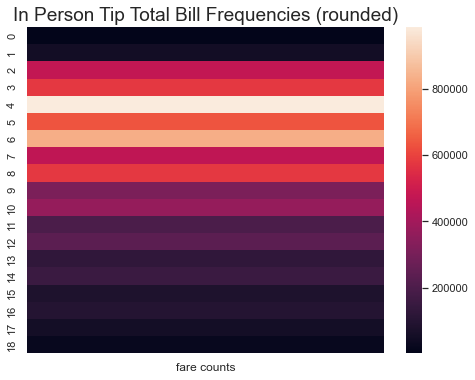

In [136]:
df_online = df_online_orig
df_in_person = df_in_person_orig

sns.set(rc={"figure.figsize":(8, 6)})
df_in_person = df_in_person[df_in_person['fare'] < 20]
df_in_person['fare'] = df_in_person['fare'].apply(round)
df_in_person = df_in_person.groupby('fare').size().reset_index(name='fare counts')
#sns.scatterplot(x='fare', y='tip_frac', data=df_in_person)
res = sns.heatmap(df_in_person[['fare counts']])
plt.title("In Person Tip Total Bill Frequencies (rounded)", fontdict = {'fontsize' : 19})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12);

In [11]:
#SSO/DSO

dfs = df

df_in_person = df
df_online = dfz

def percent_func(x):
    array = re.findall('^[^$]*$', x)
    if array != []:
        return array[0]
def contains_25(x):
    if re.findall('^.*25.*$', x) != []:
        array = re.findall('^.*25.*$', x)
        return 20
    
df_online['percent_menu_tips'] = df_online['tip_default_plan'].astype(str).apply(percent_func)
df_online['percent_menu_tips'] = df_online['percent_menu_tips'].astype(str).apply(contains_25)
df_online = df_online[df_online['percent_menu_tips'] == 20]
df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100
df_online = df_online[['percent_menu_tips', 'amount', 'tip_percent', 'gross_revenue']]
df_online['fare'] = df_online['gross_revenue']
df_online['tip'] = df_online['amount']
df_online['tip_frac'] = df_online['tip_percent']
df_online['median_menu_tip'] = df_online['percent_menu_tips']

#normalize online fare
df_online = df_online[df_online['fare'] < 100]
mean_online = np.mean(df_online['fare'])
sd_online = np.std(df_online['fare'])
def normalize_online(x):
    return (x - mean_online)/sd_online
df_online['fare'] = df_online['fare'].apply(normalize_online)
df_online = df_online[['fare', 'tip_frac']]



df_in_person = df_in_person[df_in_person['vendor'] == 'Competitor']

#normalize in_person fare
df_in_person = df_in_person[df_in_person['fare'] < 30]
mean_in_person = np.mean(df_in_person['fare'])
sd_in_person = np.std(df_in_person['fare'])
def normalize_in_person(x):
    return (x - mean_in_person)/sd_in_person
df_in_person['fare'] = df_in_person['fare'].apply(normalize_in_person)
df_in_person = df_in_person[['tip_frac', 'fare']]


same_size = 0

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

diff_size_overlap = sm.ols(formula="tip_frac ~ environment_dummy", data=df_combo).fit()
diff_size_fare_overlap = sm.ols(formula="tip_frac ~ environment_dummy + fare", data=df_combo).fit()

same_size = 1

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

same_size_overlap = sm.ols(formula="tip_frac ~ environment_dummy", data=df_combo).fit()
same_size_fare_overlap = sm.ols(formula="tip_frac ~ environment_dummy + fare", data=df_combo).fit()

In [12]:
#SSA/DSA

dfs = df

df_in_person = df
df_online = dfz
    
df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100

df_online['fare'] = df_online['gross_revenue']
df_online = df_online[df_online['fare'] < 100]
mean_online = np.mean(df_online['fare'])
sd_online = np.std(df_online['fare'])
def normalize_online(x):
    return (x - mean_online)/sd_online
df_online['fare'] = df_online['fare'].apply(normalize_online)
df_online = df_online[['fare', 'tip_frac']]

df_in_person = df_in_person[df_in_person['fare'] < 30]
mean_in_person = np.mean(df_in_person['fare'])
sd_in_person = np.std(df_in_person['fare'])
def normalize_in_person(x):
    return (x - mean_in_person)/sd_in_person
df_in_person['fare'] = df_in_person['fare'].apply(normalize_in_person)
df_in_person = df_in_person[['tip_frac', 'fare']]


same_size = 0

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

diff_size_all = sm.ols(formula="tip_frac ~ environment_dummy", data=df_combo).fit()
diff_size_fare_all = sm.ols(formula="tip_frac ~ environment_dummy + fare", data=df_combo).fit()

same_size = 1

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

same_size_all = sm.ols(formula="tip_frac ~ environment_dummy", data=df_combo).fit()
same_size_fare_all = sm.ols(formula="tip_frac ~ environment_dummy + fare", data=df_combo).fit()

In [13]:
"""

#SSCO/DSCO

def bigger_than_15(x):
    for item in x:
        if float(item) >= 15:
            return 1
    return 0

def percent_func(x):
    array = re.findall('^[^$]*$', x)
    if array != []:
        return array[0]
    
def contains_25(x):
    if re.findall('^.*25.*$', x) != []:
        array = re.findall('^.*25.*$', x)
        return 20
    
df_in_person = df
df_online = dfz


df_online['percent_menu_tips'] = df_online['tip_default_plan'].astype(str).apply(percent_func)
df_online['percent_menu_tips'] = df_online['percent_menu_tips'].astype(str).apply(contains_25)
df_online = df_online[df_online['percent_menu_tips'] == 20]
df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100
df_online['fare'] = df_online['gross_revenue']
df_online['tip'] = df_online['amount']
df_online['tip_frac'] = df_online['tip_percent']
df_online['median_menu_tip'] = df_online['percent_menu_tips']

df_in_person = df_in_person[df_in_person['vendor'] == 'Competitor']



df_online = df_online[['gross_revenue', 'amount', 'tip_default_plan']]
df_online['tip_default_plan'] = df_online['tip_default_plan'].str.replace('[%$]', '')
df_online['tip_default_plan'] = df_online['tip_default_plan'].str.split(',')
df_online['is_percent'] = df_online['tip_default_plan'].apply(bigger_than_15)

split_df = pd.DataFrame(df_online['tip_default_plan'].tolist(), columns=['low_choice', 'med_choice', 'high_choice'])
df_online = pd.concat([df_online, split_df], axis=1)


df_online_percents = df_online[df_online['is_percent'] == 1]
df_online_dollars = df_online[df_online['is_percent'] == 0]


df_online_percents['low_choice'] = (df_online_percents['low_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online_percents['med_choice'] = (df_online_percents['med_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online_percents['high_choice'] = (df_online_percents['high_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online = df_online_percents.append(df_online_dollars)


df_online['low_choice'] = (df_online['low_choice'] == df_online['amount']) * 1
df_online['med_choice'] = (df_online['med_choice'] == df_online['amount']) * 1
df_online['high_choice'] = (df_online['high_choice'] == df_online['amount']) * 1


df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100
df_online = df_online[['low_choice', 'med_choice', 'high_choice', 'amount', 'tip_percent', 'gross_revenue']].dropna()
df_online['fare'] = df_online['gross_revenue']
df_online['tip'] = df_online['amount']
df_online['tip_frac'] = df_online['tip_percent']

df_online = df_online[['tip_frac', 'low_choice', 'med_choice', 'high_choice']]
df_in_person = df_in_person[['tip_frac', 'low_choice', 'med_choice', 'high_choice']].dropna()

same_size = 0

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

diff_size_choice_overlap = sm.ols(formula="tip_frac ~ environment_dummy + low_choice + med_choice + high_choice", data=df_combo).fit()


same_size = 1

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

same_size_choice_overlap = sm.ols(formula="tip_frac ~ environment_dummy + low_choice + med_choice + high_choice", data=df_combo).fit()

"""

'\n\n#SSCO/DSCO\n\ndef bigger_than_15(x):\n    for item in x:\n        if float(item) >= 15:\n            return 1\n    return 0\n\ndef percent_func(x):\n    array = re.findall(\'^[^$]*$\', x)\n    if array != []:\n        return array[0]\n    \ndef contains_25(x):\n    if re.findall(\'^.*25.*$\', x) != []:\n        array = re.findall(\'^.*25.*$\', x)\n        return 20\n    \ndf_in_person = df\ndf_online = dfz\n\n\ndf_online[\'percent_menu_tips\'] = df_online[\'tip_default_plan\'].astype(str).apply(percent_func)\ndf_online[\'percent_menu_tips\'] = df_online[\'percent_menu_tips\'].astype(str).apply(contains_25)\ndf_online = df_online[df_online[\'percent_menu_tips\'] == 20]\ndf_online[\'tip_frac\'] = df_online[\'amount\'] / df_online[\'gross_revenue\']\ndf_online[\'tip_percent\'] = df_online[\'tip_frac\'] * 100\ndf_online[\'fare\'] = df_online[\'gross_revenue\']\ndf_online[\'tip\'] = df_online[\'amount\']\ndf_online[\'tip_frac\'] = df_online[\'tip_percent\']\ndf_online[\'median_menu_tip

In [14]:
"""

#SSCA/DSCA

def bigger_than_15(x):
    for item in x:
        if float(item) >= 15:
            return 1
    return 0
    
df_in_person = df
df_online = dfz

df_online = df_online[['gross_revenue', 'amount', 'tip_default_plan']]
df_online['tip_default_plan'] = df_online['tip_default_plan'].str.replace('[%$]', '')
df_online['tip_default_plan'] = df_online['tip_default_plan'].str.split(',')
df_online['is_percent'] = df_online['tip_default_plan'].apply(bigger_than_15)

split_df = pd.DataFrame(df_online['tip_default_plan'].tolist(), columns=['low_choice', 'med_choice', 'high_choice'])
df_online = pd.concat([df_online, split_df], axis=1)


df_online_percents = df_online[df_online['is_percent'] == 1]
df_online_dollars = df_online[df_online['is_percent'] == 0]


df_online_percents['low_choice'] = (df_online_percents['low_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online_percents['med_choice'] = (df_online_percents['med_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online_percents['high_choice'] = (df_online_percents['high_choice'].astype(float) / 100) * df_online_percents['gross_revenue']
df_online = df_online_percents.append(df_online_dollars)


df_online['low_choice'] = (df_online['low_choice'] == df_online['amount']) * 1
df_online['med_choice'] = (df_online['med_choice'] == df_online['amount']) * 1
df_online['high_choice'] = (df_online['high_choice'] == df_online['amount']) * 1


df_online['tip_frac'] = df_online['amount'] / df_online['gross_revenue']
df_online['tip_percent'] = df_online['tip_frac'] * 100
df_online = df_online[['low_choice', 'med_choice', 'high_choice', 'amount', 'tip_percent', 'gross_revenue']].dropna()
df_online['fare'] = df_online['gross_revenue']
df_online['tip'] = df_online['amount']
df_online['tip_frac'] = df_online['tip_percent']

df_online = df_online[['tip_frac', 'low_choice', 'med_choice', 'high_choice']]
df_in_person = df_in_person[['tip_frac', 'low_choice', 'med_choice', 'high_choice']].dropna()

same_size = 0

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

diff_size_choice_all = sm.ols(formula="tip_frac ~ environment_dummy + low_choice + med_choice + high_choice", data=df_combo).fit()


same_size = 1

if same_size:
    if df_online.shape[0] > df_in_person.shape[0]:
        df_online = df_online.sample(df_in_person.shape[0], replace=True)
    else:
        df_in_person = df_in_person.sample(df_online.shape[0], replace=True)

df_online['environment_dummy'] = 1
df_in_person['environment_dummy'] = 0
df_combo = df_in_person.append(df_online)

same_size_choice_all = sm.ols(formula="tip_frac ~ environment_dummy + low_choice + med_choice + high_choice", data=df_combo).fit()

"""

'\n\n#SSCA/DSCA\n\ndef bigger_than_15(x):\n    for item in x:\n        if float(item) >= 15:\n            return 1\n    return 0\n    \ndf_in_person = df\ndf_online = dfz\n\ndf_online = df_online[[\'gross_revenue\', \'amount\', \'tip_default_plan\']]\ndf_online[\'tip_default_plan\'] = df_online[\'tip_default_plan\'].str.replace(\'[%$]\', \'\')\ndf_online[\'tip_default_plan\'] = df_online[\'tip_default_plan\'].str.split(\',\')\ndf_online[\'is_percent\'] = df_online[\'tip_default_plan\'].apply(bigger_than_15)\n\nsplit_df = pd.DataFrame(df_online[\'tip_default_plan\'].tolist(), columns=[\'low_choice\', \'med_choice\', \'high_choice\'])\ndf_online = pd.concat([df_online, split_df], axis=1)\n\n\ndf_online_percents = df_online[df_online[\'is_percent\'] == 1]\ndf_online_dollars = df_online[df_online[\'is_percent\'] == 0]\n\n\ndf_online_percents[\'low_choice\'] = (df_online_percents[\'low_choice\'].astype(float) / 100) * df_online_percents[\'gross_revenue\']\ndf_online_percents[\'med_choice\']

In [15]:
stargazer = Stargazer([same_size_all, diff_size_all, same_size_overlap, diff_size_overlap, same_size_fare_all, diff_size_fare_all, same_size_fare_overlap, diff_size_fare_overlap])
stargazer.custom_columns(['SSA', 'DSA', 'SSO', 'DSO', 'SSFA', 'DSFA', 'SSFO', 'DSFO'], [1, 1, 1, 1, 1, 1, 1, 1])
stargazer.covariate_order(['Intercept', 'environment_dummy', 'fare'])
stargazer.rename_covariates({'environment_dummy': 'Environment (Online) Dummy', 'fare': 'Fare'})
stargazer.show_model_numbers(False)
stargazer.add_custom_notes(['SS-prefix indicates randomly sampled from the larger dataset as to make both the same size, DS-prefix indicates different size.',
                            'O-suffix indicates identical (overlapping) recommendations (15%, 20%, 25%). A-suffix includes all recommendations from each dataset.',
                           'F indicates that said regression includes $x_2$ (normalized fare price) in the regression.'])
stargazer